In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="3"

Sat Jan 13 22:22:26 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:1B:00.0 Off |                    0 |
| 30%   25C    P8    13W / 230W |  17558MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:1C:00.0 Off |                  Off |
| 35%   

### Model Parts

In [3]:
from model.main.enc_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.latent_layer.uniform_lse_latent_layer import LatentLayer
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *


### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 2
hp.h_dims = [32, 64, 128, 256, 512]

In [5]:
step = 0
device = 'cuda:0'

model = Model(Encoder(**hp), LatentLayer(**hp), Decoder(**hp))
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))
        
print('done')

encoder 6.004646301269531
encoder.convs 5.989013671875
encoder.linear 0.01563262939453125
latent_layer 0.0
decoder 6.044322967529297
decoder.linear 0.0234375
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train01.11-3/'
!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, net_g, _, opt_g, _ = load(save_dir, 0, model, optimizer)

total 0


### Dataset

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=128, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


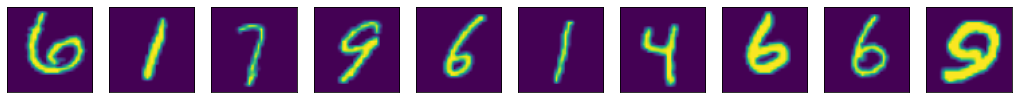

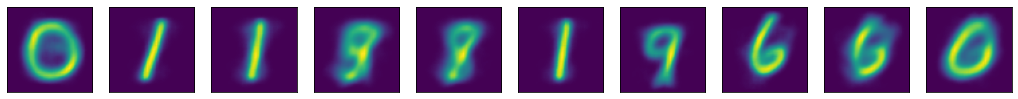

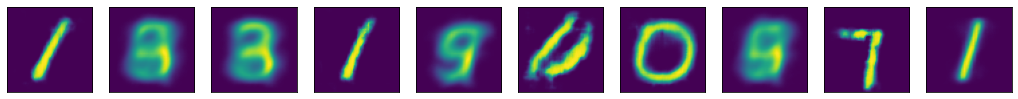

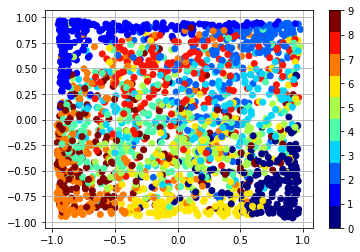

147001
lse_loss 2.4591827392578125
recon_loss 0.1726292371749878
147002
lse_loss 2.030390977859497
recon_loss 0.16562773287296295
147003
lse_loss 2.250206708908081
recon_loss 0.17167338728904724
147004
lse_loss 2.4200034141540527
recon_loss 0.17244720458984375
147005
lse_loss 2.115074396133423
recon_loss 0.16852985322475433
147006
lse_loss 2.2870941162109375
recon_loss 0.1688336580991745
147007
lse_loss 2.4453954696655273
recon_loss 0.16679207980632782
147008
lse_loss 2.076486587524414
recon_loss 0.16958990693092346
147009
lse_loss 2.452434778213501
recon_loss 0.16317546367645264
147010
lse_loss 2.3214242458343506
recon_loss 0.162401020526886
147011
lse_loss 2.0776588916778564
recon_loss 0.18978580832481384
147012
lse_loss 2.1424477100372314
recon_loss 0.1629287302494049
147013
lse_loss 2.2689597606658936
recon_loss 0.16203466057777405
147014
lse_loss 1.9929065704345703
recon_loss 0.17510919272899628
147015
lse_loss 2.314215898513794
recon_loss 0.16497984528541565
147016
lse_loss 2.069

147129
lse_loss 2.297116756439209
recon_loss 0.16136589646339417
147130
lse_loss 2.4450666904449463
recon_loss 0.17361730337142944
147131
lse_loss 2.221646785736084
recon_loss 0.17058192193508148
147132
lse_loss 2.5867292881011963
recon_loss 0.16290760040283203
147133
lse_loss 2.4267470836639404
recon_loss 0.16878525912761688
147134
lse_loss 2.2177062034606934
recon_loss 0.16271978616714478
147135
lse_loss 2.277379035949707
recon_loss 0.16249443590641022
147136
lse_loss 2.7275969982147217
recon_loss 0.16152507066726685
147137
lse_loss 2.0833966732025146
recon_loss 0.16640858352184296
147138
lse_loss 2.1610474586486816
recon_loss 0.15985265374183655
147139
lse_loss 2.1984269618988037
recon_loss 0.1699591875076294
147140
lse_loss 2.3722007274627686
recon_loss 0.1726258099079132
147141
lse_loss 2.0781846046447754
recon_loss 0.17019951343536377
147142
lse_loss 2.1430423259735107
recon_loss 0.1553269773721695
147143
lse_loss 2.7053308486938477
recon_loss 0.16520851850509644
147144
lse_loss 

147258
lse_loss 2.1440162658691406
recon_loss 0.17763245105743408
147259
lse_loss 2.1419858932495117
recon_loss 0.15835076570510864
147260
lse_loss 2.1839210987091064
recon_loss 0.15859079360961914
147261
lse_loss 2.1734814643859863
recon_loss 0.15909840166568756
147262
lse_loss 2.6165478229522705
recon_loss 0.15824106335639954
147263
lse_loss 2.3865904808044434
recon_loss 0.17666387557983398
147264
lse_loss 2.0150952339172363
recon_loss 0.16746895015239716
147265
lse_loss 2.8573052883148193
recon_loss 0.16715200245380402


KeyboardInterrupt: 

In [10]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        data = preprocess(batch)
        
        # Forward
        model.train()
        model.zero_grad()
        data = model(data, M=1000, sigma=0.045)
        
        # Backward
        loss = 0
        for key in data.keys():
            if 'loss' in key:
                loss = loss + data[key]
                writer.add_scalar(key, data[key].item(), step)
                print(key, data[key].item())
        loss.backward()
        optimizer.step()
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model.eval()
            with torch.no_grad():
                data = model(data, M=1000, sigma=1e-2)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = torch.randn(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
                
            import matplotlib.pyplot as plt
            _z = data['z'].data.cpu().numpy()
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
            plt.grid()
            plt.colorbar()
            plt.show()
        
        if step % 10000 == 0:
            save(save_dir, step, model, optimizer)
                
        step += 1
        